# Laboratory practice № 10 (Linear Quadratic Regulators & Estimators)

Done by Vladislav Diuzhev (isu: 336225, group: R33353)

Variant: 8

## Preparation

In [1]:
import matplotlib.pyplot as plt
import control as ctrl
import sympy
import numpy as np
from sympy.utilities.lambdify import lambdify
import scipy
import cvxpy as cp

In [2]:
A = np.array([
    [6, 26, 4, 17],
    [0, 9, 0, 6],
    [-10, -35, -6, -25],
    [0, -15, 0, -9]
])

B = np.array([
    [7, 0],
    [2, 0],
    [-10, 0],
    [-4, 0]
]) 

C = np.array([
    [-2, 6, -4, 2],
    [0, -4, 2, 0]
])

D = np.array([
    [0, 0],
    [0, 3]
])

In [3]:
np.linalg.eigvals(A)

array([-3.74700271e-16+2.j, -3.74700271e-16-2.j, -2.22044605e-16+3.j,
       -2.22044605e-16-3.j])

## Task 1

In [4]:
def generate_LQR(a,b,q,r):
    k, p, _ = ctrl.lqr(a,b,q,r)
    return k, p

In [5]:
def control_LQR(a,b,q,r,t):
    global ax_1
    k, p = generate_LQR(a,b,q,r)
    sys = ctrl.ss(a - b@k, np.zeros((4,1)), np.zeros((1,4)),0)
    y = ctrl.initial_response(sys,t,X0=np.ones((4,1)))
    j_teo = np.ones((4,1)).T @ p @ np.ones((4,1))
    u = -k@y.states
    j_num = np.sum(np.diagonal(y.states.T@q@y.states + u.T@r@u)*(t[-1]-t[-2]))
    print(np.linalg.eigvals(a-b@k))
    print(j_num,j_teo)
    
    ax_1[0,0].plot(t, y.states[0],label=f"$Q={q[0,0]}$, R={r[0,0]}")
    ax_1[0,0].grid()
    ax_1[0,0].legend()
    ax_1[0,0].set_title("$x_1$")
    
    ax_1[0,1].plot(t, y.states[1],label=f"$Q={q[0,0]}$, R={r[0,0]}")
    ax_1[0,1].grid()
    ax_1[0,1].legend()
    ax_1[0,1].set_title("$x_2$")
    
    ax_1[0,2].plot(t, y.states[2],label=f"$Q={q[0,0]}$, R={r[0,0]}")
    ax_1[0,2].grid()
    ax_1[0,2].legend()
    ax_1[0,2].set_title("$x_3$")
    
    ax_1[1,0].plot(t, y.states[3],label=f"$Q={q[0,0]}$, R={r[0,0]}")
    ax_1[1,0].grid()
    ax_1[1,0].legend()
    ax_1[1,0].set_title("$x_4$")
    
    ax_1[1,1].plot(t, u[0],label=f"$Q={q[0,0]}$, R={r[0,0]}")
    ax_1[1,1].grid()
    ax_1[1,1].legend()
    ax_1[1,1].set_title("$u_1$")
    
    ax_1[1,2].plot(t, u[1],label=f"$Q={q[0,0]}$, R={r[0,0]}")
    ax_1[1,2].grid()
    ax_1[1,2].legend()
    ax_1[1,2].set_title("$u_2$")

In [6]:
time_1 = np.linspace(0,30,int(30/0.005))

[-0.0991784 +2.05887259j -0.0991784 -2.05887259j -0.70030212+2.90108654j
 -0.70030212-2.90108654j]
14.200979899948102 [[14.21201459]]
[-12.15250515+0.j          -2.15196926+0.j
  -0.07424426+2.15932599j  -0.07424426-2.15932599j]
54.210327966265176 [[54.16903606]]
[-1.29921656e+02+0.j        -1.92152603e+00+0.j
 -7.22160980e-02+2.1609546j -7.22160980e-02-2.1609546j]
467.4334219618065 [[466.22947786]]


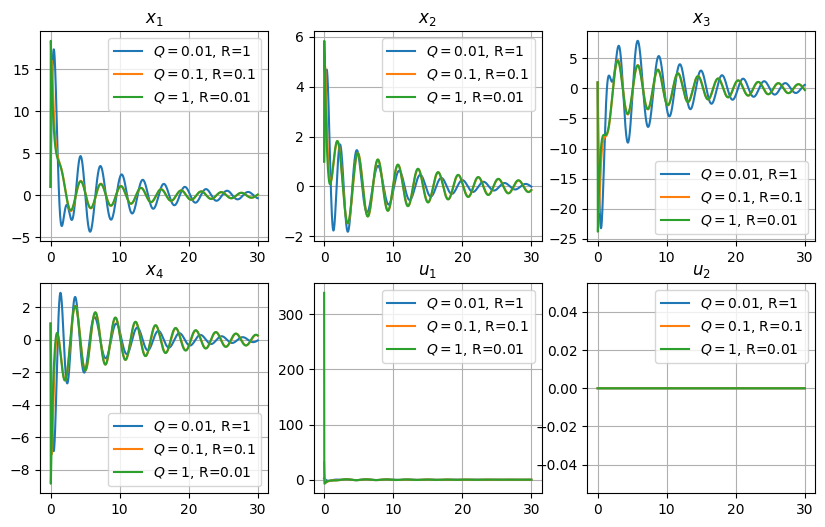

In [7]:
fig, ax_1 = plt.subplots(2,3,figsize=(10,6))
fig.suptitle(f"")
q, r = np.diag([0.01]*4), np.diag([1]*2)
control_LQR(A,B,q,r,time_1)
q, r = np.diag([0.1]*4), np.diag([0.1]*2)
control_LQR(A,B,q,r,time_1)
q, r = np.diag([1]*4), np.diag([0.01]*2)
control_LQR(A,B,q,r,time_1)

## Task 2

In [9]:
def get_K_LMI(a, b, alpha):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[P >> np.eye(4), P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0])
    prob.solve()
    return Y.value @ np.linalg.inv(P.value) 

In [17]:
time_2 = np.linspace(0,30,int(30/0.005))

In [18]:
k_lmi = get_K_LMI(A,B,0.1)

In [19]:
sys_2_lmi = ctrl.ss(A + B@k_lmi,np.zeros((4,1)),np.zeros((1,4)),0)
y_2_lmi = ctrl.initial_response(sys_2_lmi,time_2,X0=np.ones((4,1))) 

In [27]:
G_2 = np.array([
    [-1, 1, 0, 0],
    [0, -1, 1, 0],
    [0, 0, -1, 1],
    [0, 0, 0, -1]
])
Y_2 = np.array([
    [1,1,1,1],
    [1,1,1,1]
]).reshape((2,-1))
P_2 = scipy.linalg.solve_sylvester(A,-G_2,B@Y_2)
k_2_mod = -Y_2 @ np.linalg.pinv(P_2)
sys_2_mod = ctrl.ss(A + B@k_2_mod,np.zeros((4,1)),np.zeros((1,4)),0)
y_2_mod = ctrl.initial_response(sys_2_mod,time_1,X0=np.ones((4,1)))

In [28]:
np.linalg.eigvals(A+B@k_2_mod)

array([-1.00113888+0.00113939j, -1.00113888-0.00113939j,
       -0.99886112+0.00113837j, -0.99886112-0.00113837j])

[-12.15250515+0.j          -2.15196926+0.j
  -0.07424426+2.15932599j  -0.07424426-2.15932599j]
542.1032796625701 [[541.69036057]]


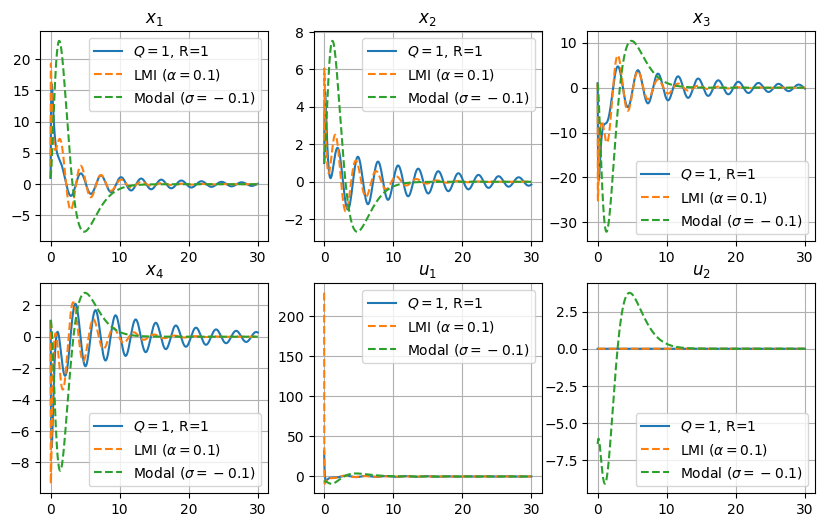

In [32]:
fig, ax_1 = plt.subplots(2,3,figsize=(10,6))
fig.suptitle(f"")
q, r = np.diag([1]*4), np.diag([1]*2)
control_LQR(A,B,q,r,time_2)

ax_1[0,0].plot(time_2, y_2_lmi.states[0],linestyle="--",label="LMI ($\\alpha=0.1$)")
ax_1[0,1].plot(time_2, y_2_lmi.states[1],linestyle="--",label="LMI ($\\alpha=0.1$)")
ax_1[0,2].plot(time_2, y_2_lmi.states[2],linestyle="--",label="LMI ($\\alpha=0.1$)")
ax_1[1,0].plot(time_2, y_2_lmi.states[3],linestyle="--",label="LMI ($\\alpha=0.1$)")
ax_1[1,1].plot(time_2, (k_lmi@y_2_lmi.states)[0],linestyle="--",label="LMI ($\\alpha=0.1$)")
ax_1[1,2].plot(time_2, (k_lmi@y_2_lmi.states)[1],linestyle="--",label="LMI ($\\alpha=0.1$)")

ax_1[0,0].plot(time_2, y_2_mod.states[0],linestyle="--",label="Modal ($\sigma=-0.1$)")
ax_1[0,1].plot(time_2, y_2_mod.states[1],linestyle="--",label="Modal ($\sigma=-0.1$)")
ax_1[0,2].plot(time_2, y_2_mod.states[2],linestyle="--",label="Modal ($\sigma=-0.1$)")
ax_1[1,0].plot(time_2, y_2_mod.states[3],linestyle="--",label="Modal ($\sigma=-0.1$)")
ax_1[1,1].plot(time_2, (k_2_mod@y_2_mod.states)[0],linestyle="--",label="Modal ($\sigma=-0.1$)")
ax_1[1,2].plot(time_2, (k_2_mod@y_2_mod.states)[1],linestyle="--",label="Modal ($\sigma=-0.1$)")

ax_1[0,0].legend()
ax_1[0,1].legend()
ax_1[0,2].legend()
ax_1[1,0].legend()
ax_1[1,1].legend()
ax_1[1,2].legend()

## Task 3

In [73]:
stds_Q = [1, 5, 10]
stds_R = [1, 5, 10]

In [35]:
def generate_Kalman(a, c, std_q, std_r):
    q, r = np.diag(std_q)**2, np.diag(std_r)**2
    l, p, _ = ctrl.lqe(a,np.eye(4),c,q,r)
    return l, p 

In [71]:
def observe_Kalman(a,c,std_q,std_r,std_f,std_xi,t):
    l, _ = generate_Kalman(a,c,std_q,std_r)
    f, xi = np.random.normal(0,std_f,(len(t),4)), np.random.normal(0,std_xi,(len(t),2))
    sys = ctrl.ss(a, np.eye(4),c,0)
    sys_obs = ctrl.ss(a - l@c,l,c,0) 
    y = ctrl.forced_response(sys,t,X0=np.ones((4,1)),U=f.reshape((4,-1)))
    y_obs = ctrl.forced_response(sys_obs,t,X0=np.array([[10],[4],[-10],[5]]),U=y.outputs+xi.reshape((2,-1)))
    fig, ax = plt.subplots(2,3,figsize=(10,6))
    fig.suptitle(f"$\sigma_f={std_f}$, $\sigma_\\xi={std_xi}$, $Q=diag({std_q})^2$, $R=diag({std_r})^2$")
    ax[0,0].plot(t, y.states[0],label="$x_1$")
    ax[0,0].plot(t, y_obs.states[0],"r--",label="$\hat{x}_1$")
    ax[0,0].grid()
    ax[0,0].legend()
    
    ax[0,1].plot(t, y.states[1],label="$x_2$")
    ax[0,1].plot(t, y_obs.states[1],"r--",label="$\hat{x}_2$")
    ax[0,1].grid()
    ax[0,1].legend()
    
    ax[0,2].plot(t, y.states[2],label="$x_3$")
    ax[0,2].plot(t, y_obs.states[2],"r--",label="$\hat{x}_3$")
    ax[0,2].grid()
    ax[0,2].legend()
    
    ax[1,0].plot(t, y.states[3],label="$x_4$")
    ax[1,0].plot(t, y_obs.states[3],"r--",label="$\hat{x}_4$")
    ax[1,0].grid()
    ax[1,0].legend()
    
    ax[1,1].plot(t, y.outputs[0] + xi.reshape((2,-1))[0],label="$y_1$")
    ax[1,1].plot(t, y_obs.outputs[0],"--",label="$\hat{y}_1$")
    ax[1,1].grid()
    ax[1,1].legend()
    
    ax[1,2].plot(t, y.outputs[1] + xi.reshape((2,-1))[1],label="$y_2$")
    ax[1,2].plot(t, y_obs.outputs[1],"--",label="$\hat{y}_2$")
    ax[1,2].grid()
    ax[1,2].legend()

In [72]:
time_3 = np.linspace(0,5,int(5/0.001))

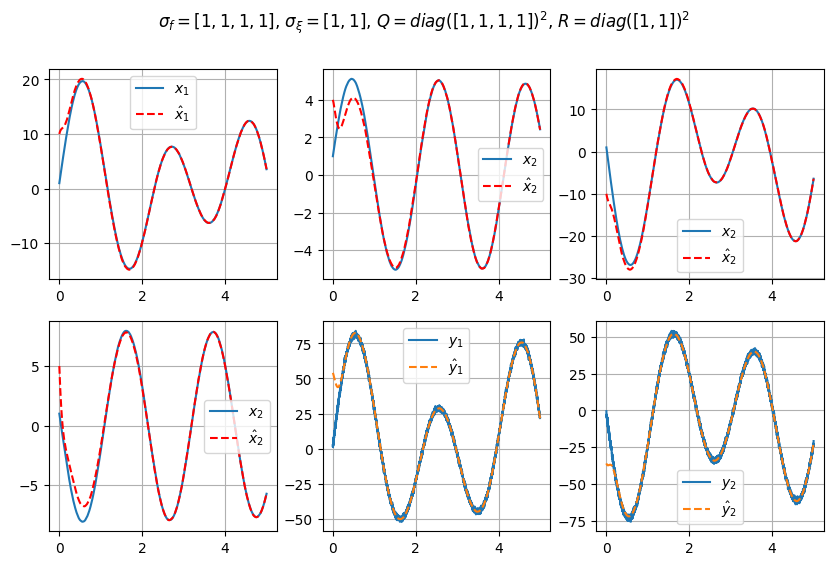

In [74]:
std_q, std_r = [1,1,1,1], [1,1]
std_f, std_xi = [1,1,1,1], [1,1]
observe_Kalman(A,C,std_q,std_r,std_f,std_xi,time_3)

## Task 4

In [33]:
Q_c, R_c = np.diag([0.1]*4), np.diag([0.1]*2)
Q_std, R_std = [1,1,1,1], [1,1]

In [36]:
K, _ = generate_LQR(A,B,Q_c,R_c)
L, _ = generate_Kalman(A,C,Q_std,R_std)
K = -K
L = -L

In [39]:
A_new = np.block([
    [A + B@K, -B@K],
    [np.zeros_like(A), A + L@(C)]
]) 
B_new = np.block([
    [np.identity(4),np.zeros((4,2))],
    [np.identity(4),L]
])

time_4 = np.linspace(0,5,int(5/0.001))
sys = ctrl.ss(A_new,B_new,np.zeros((1,8)),0)
force = np.random.normal(0,Q_std+R_std,(len(time_4),6))
y_4 = ctrl.forced_response(sys,T=time_4,X0=[-1,-1,-1,-1,2,2,2,2],U=force.reshape((6,-1)))

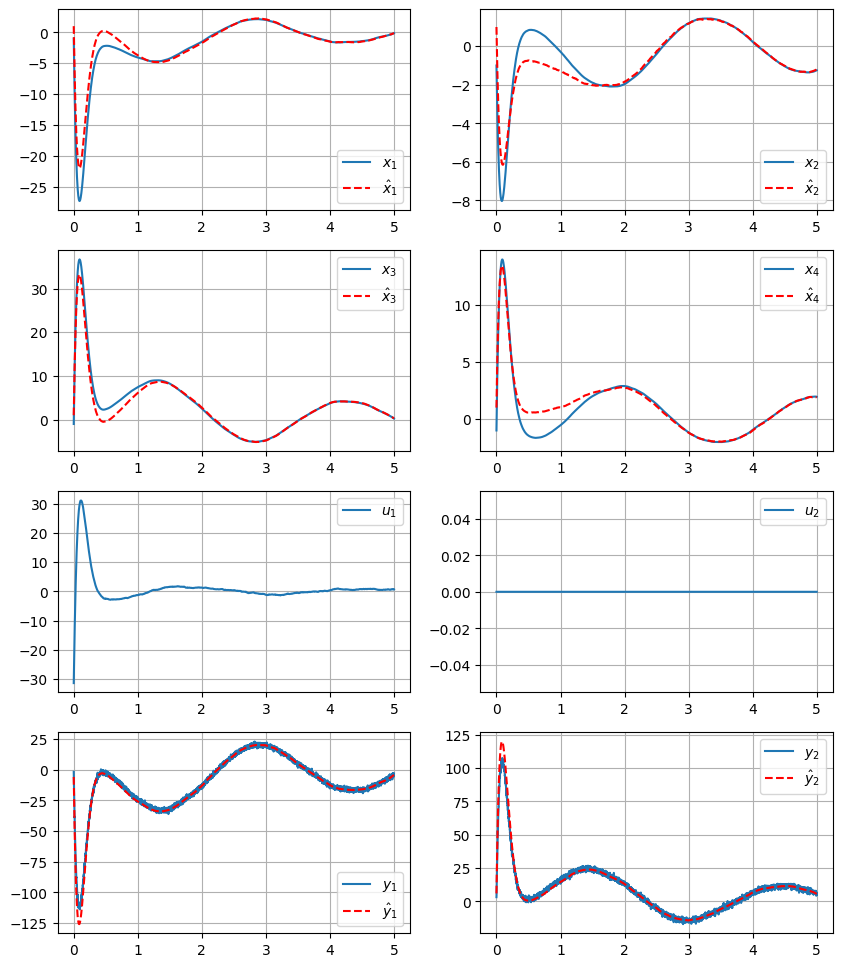

In [58]:
fig, ax = plt.subplots(4,2,figsize=(10,12))
# fig.suptitle(f"$\sigma_f={std_f}$, $\sigma_\\xi={std_xi}$, $Q=diag({std_q})^2$, $R=diag({std_r})^2$")
ax[0,0].plot(time_4, y_4.states[0],label="$x_1$")
ax[0,0].plot(time_4, y_4.states[0] + y_4.states[4],"r--",label="$\hat{x}_1$")
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(time_4, y_4.states[1],label="$x_2$")
ax[0,1].plot(time_4, y_4.states[1] + y_4.states[5],"r--",label="$\hat{x}_2$")
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(time_4, y_4.states[2],label="$x_3$")
ax[1,0].plot(time_4, y_4.states[2] + y_4.states[6],"r--",label="$\hat{x}_3$")
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].plot(time_4, y_4.states[3],label="$x_4$")
ax[1,1].plot(time_4, y_4.states[3] + y_4.states[7],"r--",label="$\hat{x}_4$")
ax[1,1].grid()
ax[1,1].legend()

ax[2,0].plot(time_4, (K@y_4.states[:4,:])[0],label="$u_1$")
ax[2,0].grid()
ax[2,0].legend()

ax[2,1].plot(time_4, (K@y_4.states[:4,:])[1],label="$u_2$")
ax[2,1].grid()
ax[2,1].legend()


ax[3,0].plot(time_4, (C@y_4.states[:4]+D@K@(y_4.states[:4]-y_4.states[4:]) + force[:,4:].reshape((2,-1)))[0],label="$y_1$")
ax[3,0].plot(time_4, (C@(y_4.states[:4]-y_4.states[4:])+D@K@(y_4.states[:4]-y_4.states[4:]))[0],"r--",label="$\hat{y}_1$")
ax[3,0].grid()
ax[3,0].legend()

ax[3,1].plot(time_4, (C@y_4.states[:4]+D@K@(y_4.states[:4]-y_4.states[4:]) + force[:,4:].reshape((2,-1)))[1],label="$y_2$")
ax[3,1].plot(time_4, (C@(y_4.states[:4]-y_4.states[4:])+D@K@(y_4.states[:4]-y_4.states[4:]))[1],"r--",label="$\hat{y}_2$")
ax[3,1].grid()
ax[3,1].legend()

In [46]:
force[:,:4].reshape((4,-1)).shape

(4, 5000)

((2, 4), (4, 5000))